<a href="https://colab.research.google.com/github/mashrukh-zaman/BanglaNet/blob/main/BanglaNet_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime,os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation,BatchNormalization,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam

#Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
data_root = Path('/content/drive/My Drive/Desi imagenet')
print('data_root:', data_root)

data_root: /content/drive/My Drive/Desi imagenet


In [ ]:
Dim = 256
batch_size = 20
Num_class = 13

train_steps_per_epoch = 1499// batch_size
val_steps_per_epoch = 366 // batch_size
test_steps_per_epoch = 198 // batch_size

In [ ]:
datagen=ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

train_gen = datagen.flow_from_directory(data_root/'Train', target_size = (Dim, Dim),batch_size = 10,subset = 'training')
val_gen = datagen.flow_from_directory(data_root/'Train', target_size = (Dim, Dim), batch_size = 10,subset = 'validation')

Found 1420 images belonging to 13 classes.
Found 349 images belonging to 13 classes.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


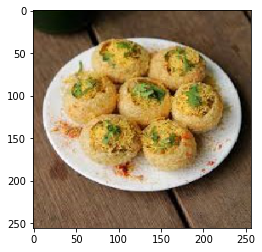

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


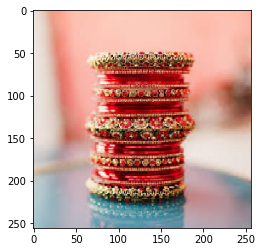

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


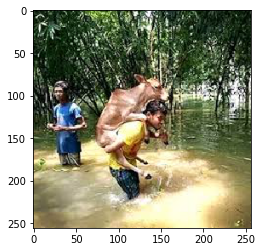

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


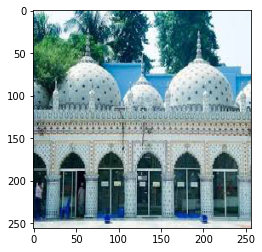

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


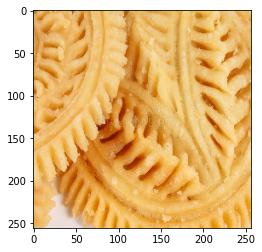

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


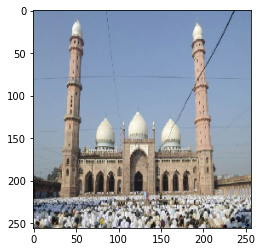

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


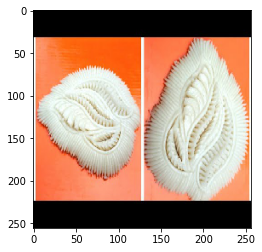

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


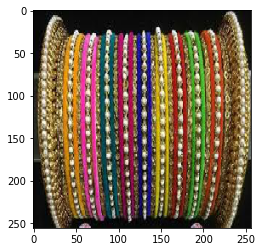

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


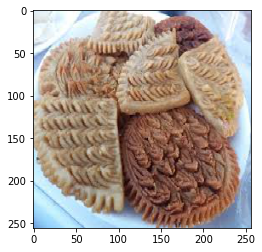

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


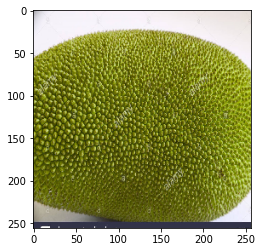

In [ ]:
x_batch,y_batch = next(train_gen) #Next: The next() function returns the next item from the iterator.​ 
                                 #Here, in traingen, the next function takes image with corresponding class according to its batch size. And use it to visualize the images.
for i in range (0,10):   
  image = x_batch[i]  
  plt.imshow(image, cmap = 'gray')
  print(y_batch[i])
  plt.show()

In [ ]:
model = Sequential()
densenet = DenseNet201(include_top=False, 
               weights='imagenet' , 
               input_shape = (Dim, Dim, 3), 
               pooling='avg')
model.add(densenet)
model.add(Dense(64, kernel_regularizer = l2(0.001), activation = 'sigmoid'))
model.add(Dropout(0.25)) #hyperparameter changed, randomley select some layer and exclude them in the next step, we changed this value in order to remove uncessary layer and overfitting problem 
model.add(Dense(64, kernel_regularizer = l2(0.001),activation = 'sigmoid'))
model.add(Dropout(0.25)) #Now we will make a dropout layer to prevent overfitting, which functions by randomly eliminating some of the connections between the layers (0.2 means it drops 20% of the existing connections):
model.add(Dense(Num_class, activation = 'softmax')) #softmax is used here because the last layer decide which class the image belong to,as it is a multi class dataset, softmax is the idea choice for multi class classification 


print('finished loading model.')

74842112/74836368 [==============================] - 1s 0us/step
finished loading model.


In [ ]:
model.compile(optimizer = Adam(lr=3e-4),loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense (Dense)                (None, 64)                122944    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                845       
Total params: 18,449,933
Trainable params: 18,220,877
Non-trainable params: 229,056
______________________________________

In [ ]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss',patience = 10)

cb_checkpointer=ModelCheckpoint(filepath='/content/drive/My Drive/Desi imagenet/densenet.hdf5',
                               monitor = 'val_loss',
                               save_best_only = True,
                               mode = 'auto')

reducelr=ReduceLROnPlateau(monitor = 'val_loss', 
                           factor = 0.2, 
                           patience = 5, 
                           min_lr = 5e-4)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
fit_history=model.fit_generator(train_gen,steps_per_epoch = train_steps_per_epoch,
                                epochs = 50, validation_data=val_gen,
                                validation_steps = val_steps_per_epoch,
                                callbacks  =[cb_checkpointer,cb_early_stopper,reducelr, tensorboard_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
 1/74 [..............................] - ETA: 0s - loss: 3.4694 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
64/74 [========================>.....] - ETA: 58s - loss: 2.6196 - accuracy: 0.1922 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


74/74 [==============================] - 565s 8s/step - loss: 2.5667 - accuracy: 0.2176 - val_loss: 2.2721 - val_accuracy: 0.4056
Epoch 2/50
74/74 [==============================] - 249s 3s/step - loss: 2.1336 - accuracy: 0.4486 - val_loss: 1.9850 - val_accuracy: 0.6500
Epoch 3/50
74/74 [==============================] - 140s 2s/step - loss: 1.9126 - accuracy: 0.5851 - val_loss: 1.7397 - val_accuracy: 0.8167
Epoch 4/50
74/74 [==============================] - 65s 878ms/step - loss: 1.8098 - accuracy: 0.6203 - val_loss: 1.5492 - val_accuracy: 0.8722
Epoch 5/50
74/74 [==============================] - 44s 599ms/step - loss: 1.6339 - accuracy: 0.7054 - val_loss: 1.6074 - val_accuracy: 0.7889
Epoch 6/50
74/74 [==============================] - 40s 545ms/step - loss: 1.5401 - accuracy: 0.7635 - val_loss: 1.2667 - val_accuracy: 0.9278
Epoch 7/50
74/74 [==============================] - 29s 392ms/step - loss: 1.3877 - accuracy: 0.8162 - val_loss: 1.1924 - val_accuracy: 0.9500
Epoch 8/50
74/74

In [ ]:
%tensorboard --logdir logs

In [ ]:
model.load_weights('/content/drive/My Drive/Desi imagenet/densenet.hdf5')
print('model weights loaded')

test_gen = datagen.flow_from_directory(data_root/'Test',
                                       target_size = (Dim,Dim),
                                       batch_size = 10,
                                       shuffle = False)

#test_gen.reset()
pred=model.predict_generator(test_gen,
                             steps = test_steps_per_epoch ,
                             verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)
print(predicted_class_indices[89])

model weights loaded
Found 193 images belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
9/9 [==============================] - 46s 5s/step
11


In [ ]:
score2 = model.evaluate(val_gen)
print('Validation loss', score2[0])
print('Validation accuracy', score2[1])

35/35 [==============================] - 6s 168ms/step - loss: 0.2794 - accuracy: 0.9885
Validation loss 0.27941206097602844
Validation accuracy 0.9885386824607849
